In [184]:
#import
import numpy as np 
from PIL import Image
import pydicom as dicom
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from lime import lime_image

import matplotlib.pyplot as plt 
from skimage.segmentation import mark_boundaries

#모델 로드
loaded = keras.models.load_model("C:\\Users\\user\\Desktop\\실리콘밸리 온라인 인턴십\\model\\resnet50_0712_model.h5")


In [197]:
image_path = "C:\\Users\\user\\Desktop\\실리콘밸리 온라인 인턴십\\rsna-intracranial-hemorrhage-detection\\train\\"
hem = ["ID_2685000bd","ID_2877680fb"]


In [186]:
def window_image(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

# Save different images as R, G, B: in 3 dimensions
def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    #brain_img = (brain_img - 0) / 80
    #subdural_img = (subdural_img - (-20)) / 200
    #soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    bsb_img = Image.fromarray(np.uint8(bsb_img))
    return bsb_img

def dicom2nparray(dcm_file_path):
    dcm_file = dicom.read_file(dcm_file_path)
    dcm_pixel = dcm_file.pixel_array

    img_array = (dcm_pixel-np.min(dcm_pixel))/(np.max(dcm_pixel)-np.min(dcm_pixel))*255.0
    img_array = cv2.resize( img_array ,  (224,224) )
    #plt.imshow(dcm_pixel , cmap="bone")
    return img_array

def preprocess(dcm_file_path):
    dcm_file = dicom.read_file(dcm_file_path)
    
    #p_id = dcm_file.PatientID

    img = bsb_window(dcm_file)
    img = np.array(img)/255.0
    img = cv2.resize(img , (224,224))
    img = np.expand_dims(img , axis = 0) 

    return img

In [ ]:
dcm_file_path = f"{image_path}{hem[1]}.dcm"

In [195]:
def masking(id):
    original_img = dicom2nparray(f"{image_path}{id}.dcm")
    plt.imshow(original_img , cmap="gray")
    np.min(original_img),np.max(original_img),original_img.shape
    dcm_file_path = f"{image_path}{id}.dcm"
    pre_img = preprocess(dcm_file_path)

    print(hem[1])

    #모델의 결과값 받아오기
    ml_result = loaded.predict(pre_img)

    print(ml_result[0][0])

    print(int(ml_result))
    #Lime 함수에도 전처리된 이미지 넣고,


    #Lime 결과값 받아오기

    explainer = lime_image.LimeImageExplainer(verbose = False)

    explanation = explainer.explain_instance(
        pre_img[0], 
        classifier_fn = loaded.predict, 
        top_labels=5, 
        hide_color=0, 
        num_samples= 50
    )

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)

    plt.imshow(temp)
    plt.axis('off')
    plt.show()
    plt.imshow(mask)
    plt.axis('off')
    plt.show()
    np.unique(mask)

    color_img = np.expand_dims(original_img , axis = -1)
    color_img = cv2.cvtColor(np.uint8(color_img),cv2.COLOR_GRAY2RGB)
    color_img[mask != 0] = [255, 0, 0]

    plt.imshow(color_img)
    plt.axis('off')
    plt.show()

    img_save = Image.fromarray(color_img)
    img_save.save(f"C:\\Users\\user\\Desktop\\실리콘밸리 온라인 인턴십\\dcm\\lime\\{id}.jpg")
    plt.imshow(original_img , cmap="gray") 
    plt.axis('off')
    plt.show()

    color_img

ID_2877680fb
1/1 [==============================] - 0s 21ms/step
2.0952964e-05
0


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


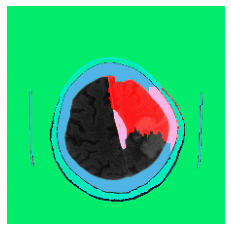

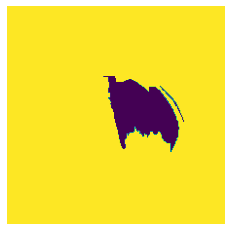

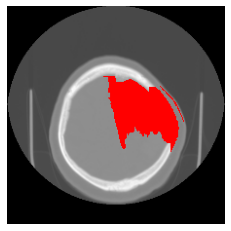

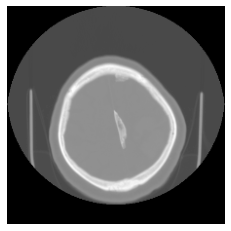

ID_2877680fb
1/1 [==============================] - 0s 18ms/step
0.028435806
0


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


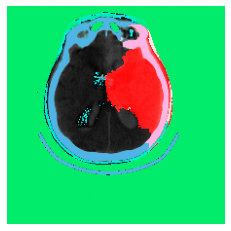

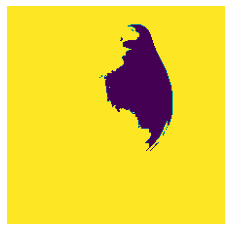

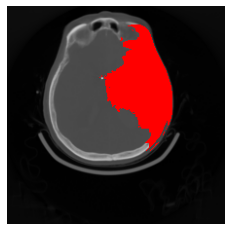

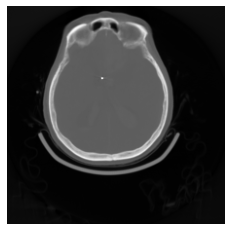

In [198]:
for id in hem:
    masking(id)